# Reading the data

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

base_dir = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet"
df = pd.read_parquet(f'{base_dir}/partition_id=7/part-0.parquet')

df_pl = pl.read_parquet(f'{base_dir}/partition_id=7/part-0.parquet')

# Exploring the data

### Dataset Info

- **79 features and 9 responders**
  - *Anonymized but representing real market data. The training set contains historical data and returns.*

- **date_id** and **time_id**  
  - *Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between time_id values may vary.*

- **symbol_id**  
  - *Identifies a unique financial instrument.*

- **weight**  
  - *The weighting used for calculating the scoring function.*

- **feature_{00...78}**  
  - *Anonymized market data.*

- **responder_{0...8}**  
  - *Anonymized responders clipped between -5 and 5. The `responder_6` field is what we are trying to predict.*

### Goal
- Predict `responder_6`.
 responder_6 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335560 entries, 0 to 6335559
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [3]:
empty_columns = []
fully_filled_columns = []
partially_empty_columns = []



## pl
for feature in df_pl.columns:
    # Count empty and non-empty rows
    empty_rows = df_pl[feature].is_null().sum()
    nonempty_rows = len(df_pl[feature]) - empty_rows



    # Classify the columns based on the counts

    if nonempty_rows == 0:
        empty_columns.append(feature)
    elif empty_rows == 0:
        fully_filled_columns.append(feature)
    else:
        partially_empty_columns.append(feature)

    # Print feature statistics
    print(f'{feature} : total - {len(df_pl[feature])} - empty - {empty_rows} - nonempty - {nonempty_rows}')


date_id : total - 6335560 - empty - 0 - nonempty - 6335560
time_id : total - 6335560 - empty - 0 - nonempty - 6335560
symbol_id : total - 6335560 - empty - 0 - nonempty - 6335560
weight : total - 6335560 - empty - 0 - nonempty - 6335560
feature_00 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_01 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_02 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_03 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_04 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_05 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_06 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_07 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_08 : total - 6335560 - empty - 75504 - nonempty - 6260056
feature_09 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_10 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_11 : total - 6335560 - empty - 0 - nonempty - 6335560
feature_12 : to

In [4]:
from IPython.display import display

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

    display(df.describe().drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis = 1).drop('count',axis = 0).T.style.background_gradient(cmap='coolwarm'))

,mean,std,min,25%,50%,75%,max
feature_00,1.070064,1.283013,-3.847566,0.121829,0.843269,2.080291,4.598825
feature_01,0.016119,1.219514,-4.471971,-0.855983,0.071036,0.883402,6.184477
feature_02,1.071795,1.276411,-2.597594,0.120580,0.840165,2.069826,4.625466
feature_03,1.071449,1.277353,-3.971338,0.121107,0.840640,2.073104,4.646819
feature_04,0.006477,1.133789,-4.245502,-0.797053,0.025471,0.816409,4.310173
feature_05,-0.120161,1.082332,-25.350399,-0.578960,-0.097576,0.357883,28.065392
feature_06,-0.013713,1.143736,-38.520802,-0.489110,-0.010745,0.453429,46.969715
feature_07,-0.043206,1.134917,-21.773184,-0.518946,-0.051584,0.415307,54.941608
feature_08,0.286873,1.094320,-10.963705,-0.256547,0.202659,0.736377,21.695173
feature_09,32.529870,23.693359,2.000000,11.000000,30.000000,50.000000,82.000000


In [5]:
print(df[df.date_id==0].symbol_id.unique())
print(df[df.date_id==1].symbol_id.unique())
print(df[df.symbol_id == 1].date_id.unique())

print(set(df[df.symbol_id == 1].date_id.unique()) - set(df[df.symbol_id == 7].date_id.unique()))

[]
[]
[1190 1191 1192 1193 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204
 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218
 1219 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232
 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1248
 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262
 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276
 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290
 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304
 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318
 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332
 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346
 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359]
{1197}


In [6]:
mask1 = (df.symbol_id == 1) & (df.date_id == 0)

mask2 = (df.symbol_id == 7) & (df.date_id == 0)

list(set(df[mask1].time_id.unique()) - set(df[mask2].date_id.unique()))[:10]

[]

# Data Processing

In [7]:
columns_to_drop = [f"responder_{i}" for i in range(9) if f"responder_{i}" in df.columns]
columns_to_drop.remove('responder_6')
df = df.drop(columns = columns_to_drop)
df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,1190,0,0,2.888326,0.928983,0.441290,1.352455,1.301461,2.302733,-0.231061,...,-1.112638,-0.126700,-0.550691,NaN,NaN,-0.226759,-0.284071,-0.220763,-0.203992,-0.278927
1,1190,0,1,5.419313,1.793786,0.198769,1.165048,0.392095,2.187486,-0.220963,...,-1.128376,-0.284510,-0.677577,NaN,NaN,-0.204890,-0.263358,-0.207352,-0.289453,-0.541755
2,1190,0,2,1.286522,1.177853,0.071345,1.043871,1.246540,1.825975,-0.283726,...,-0.873979,0.842998,-0.481638,NaN,NaN,-0.304970,-0.252092,-0.279336,-0.304391,3.743622
3,1190,0,3,1.223723,1.093739,-0.049899,0.715656,0.709871,1.136459,-0.194208,...,-0.778312,1.979528,-0.061848,NaN,NaN,5.655631,5.656282,1.698300,1.530262,3.072302
4,1190,0,4,1.949932,1.186918,0.294662,0.873467,0.810031,2.020650,-0.113065,...,-0.898841,-0.054270,-0.621782,NaN,NaN,0.126787,0.223887,-0.120427,-0.140796,-2.281883


## Percentage Based Column Filtering

In [8]:
# Sort the DataFrame
# The symbol_id refers to the individual stock. Since this data is chronological. 
# It must be sorted into groups: by stock then day, then time.

df = df.sort_values(by=['symbol_id', 'date_id', 'time_id'])
df = df.reset_index(drop=True)
df.head(100)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,1190,0,0,2.888326,0.928983,0.441290,1.352455,1.301461,2.302733,-0.231061,...,-1.112638,-0.126700,-0.550691,NaN,NaN,-0.226759,-0.284071,-0.220763,-0.203992,-0.278927
1,1190,1,0,2.888326,0.812045,0.287618,0.781931,0.862262,1.999738,-0.078465,...,-0.845442,-0.296608,-0.524439,NaN,NaN,-0.283554,-0.251792,-0.365122,-0.294544,-0.492223
2,1190,2,0,2.888326,1.564986,0.848806,0.845978,0.934356,2.146238,-0.020378,...,-1.041165,-0.317506,-0.613696,NaN,NaN,-0.259325,-0.219117,-0.367411,-0.194655,-1.118208
3,1190,3,0,2.888326,1.646784,0.556938,1.245883,1.384533,2.333363,-0.051726,...,-0.414754,-0.316095,-0.544095,NaN,NaN,-0.297573,-0.279133,-0.232264,-0.308909,-0.550099
4,1190,4,0,2.888326,1.048084,0.593710,0.952669,1.393819,1.513835,-0.096590,...,-0.612275,0.240563,-0.614175,NaN,NaN,-0.268121,-0.265241,-0.294448,-0.297132,-0.567549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1190,95,0,2.888326,0.899313,0.872655,0.611904,0.800270,1.672438,0.091263,...,0.015106,0.546566,0.541074,-0.310604,-0.366859,-0.347108,-0.116420,-0.225704,-0.238560,-0.069689
96,1190,96,0,2.888326,1.152360,0.658832,0.786550,0.733082,1.936692,-0.055169,...,0.022601,0.313902,0.375344,-0.306194,-0.264463,-0.302172,-0.187144,-0.297502,-0.291433,-0.130946
97,1190,97,0,2.888326,0.951265,0.968181,1.005434,0.923703,1.711512,-0.090984,...,0.008565,-0.073943,0.190520,-0.414845,-0.362990,-0.255631,-0.228114,-0.360115,-0.235122,-0.174573
98,1190,98,0,2.888326,0.944483,1.020565,0.983124,0.972003,1.554945,-0.003110,...,0.049329,0.445988,0.297129,-0.298602,-0.360960,-0.303206,-0.261873,-0.201067,-0.336540,0.150257


From the data exploration we saw that each feature column is not completely full. There are random points at which there are NANs or empty datapoints. <br>

Thus, need to be accounted for in some way. <br>

Our method is to process the data frame by stock (symbol_id). Each group contains all the time data (features) for a given stock. Our goal is to check the percentage of missing rows (NANs) for each group and individual feature. <br>

- If a feature for a stock is completely missing we drop the feature for the whole dataframe not just the group/stock.
- If the number of missing rows for a feature of a given stock exceeds a given percentage threshold, then the feature is also dropped for the whole dataframe. In this code the percentage threshold can be easily altered and is arbitrarily set to 10%.
- If there are any empty rows for the feature in that group then we forward and back fill those rows. Since the data is chronologically sorted in the previous step, ffill() and bfill() take the previous or forward time step data. They do not take random data from some other place in time. 
- If there are no empty rows nothing happens

The code uses lists: dropped columns, filled columns, and percent filled. These are used to track the changes to the dataframe and print out the changes made in the data preprocessing for each group. The processed_groups dataframe is used to store the changes of all the groups.

In [9]:
# The % threshold of missing values for a given symbol_ID group at which to delete a feature from the whole df.
percentage_threshold = 10.0

# The processed_groups dataframe is used to store the changes for a given symbol ID.
processed_groups = pd.DataFrame(columns = ['Symbol ID', 'Dropped Columns', 'Filled Columns', '% Filled'])


# Iterates on the df into groups by symbol ID. These are already sorted by symbol, time, and date in the previous step
for symbol_id, group in df.groupby('symbol_id'):
    
    # lists to store the changes made to each group
    dropped_columns = []
    filled_columns = []
    percent_filled = []

    for feature in group.columns:
        # calculates percentage of missing rows for a feature in the group
        total_rows = len(group)
        empty_rows = group[feature].isnull().sum()
        empty_rows_percentage = (empty_rows / total_rows) * 100
        nonempty_rows_percentage = 100 - empty_rows_percentage
        
        # if the feature is empty or the % threshold of missing rows is exceeded --> delete the feature from the df
        if empty_rows == total_rows or empty_rows_percentage >= percentage_threshold:
            df = df.drop(columns=feature)
            dropped_columns.append(feature)


        # Forward-fill and backward-fill missing values if lower than threshold and empty rows exist
        elif empty_rows > 0:     
            df.loc[group.index,feature] = group[feature].ffill().bfill()
            filled_columns.append(feature)
            percent_filled.append(empty_rows_percentage)



    # Check if there is data to add to the df for a given symbol_id group
    if dropped_columns or filled_columns or percent_filled:
        new_row = pd.DataFrame({
            'Symbol ID': [symbol_id],
            'Dropped Columns': [dropped_columns],
            'Filled Columns': [filled_columns],
            '% Filled': [percent_filled]
        })
    processed_groups = pd.concat([processed_groups, new_row], ignore_index=True)




# print(processed_groups)

In [10]:
# This is just a double check if there any missing rows left

null_columns = df.columns[df.isnull().any()]
print(null_columns)


Index([], dtype='object')


## Principal Component Analysis - PCA

One way to get rid of features and to reduce the size of our large data set is through Principal Component Analysis. <br>

PCA transforms the feature set into a smaller and new set of uncorrelated variables called principal components (PCs). Our original feature set has 79 un-named features that we know nothing about. They could have linear relationships between them (they could be inter-correlated) that makes using all 79 features redundant and computationally expensive. It could also lead to overfitting. PCA helps to solve this by reducing the dimensionality of the data into a set of uncorrelated PCs. Each PC is essentially a distillation/reduction of the feature set. The PCs capture the most significant variations in the data as possible. These are new variables created by linear combinations of the original variables, where the first principal component (PC #1) explains the most variance in the data. The subsequent components progressively explain less and less variance (PC #2, PC #3, etc.). PCA inherently removes multicollinearity between the features by transforming the features into orthogonal PCs.

How the algorithm works:
* calculate the covariance matrix of the data to determines the relationships between variables. 
* The covariance matrix is then decomposed into eigenvalues and eigenvector. The eigenvectors represent the directions of maximum variance and the eigenvalues represent the amount of variance explained by each component
* A subset of principal components with the highest variance are chosen to represent the feature set. These are specified when running the model.

However the data must be normalized first before running principle component analysis.
* PCA works by identifying the directions (principal components) that maximize the variance in the data. If the features have different scales (e.g., one feature ranges from 0 to 1, while another ranges from 0 to 1000), the variance of the features with larger ranges will dominate. This would cause PCA to incorrectly weight those features in its calculations.


Thus we must use Standard Scaler before before implementingre PCA. <br>

Standard Scaler ensures:
* All features are centered around 0 with unit variance (mean = 0, variance = 1).
* The variance of each feature contributes equally when PCA calculates the covariance matrix of the feature set

However standard scaler must be performed on the individual symbol_id groups (the full set of date and time id's for a given symbol id). Normalizing each group independently is necessary as each symbol id represents distinct entities (individual stocks) with no shared scale or distribution. At least we have no way on knowing since the data is unlabeled. Thus to be safe, we decided to apply standard scaler on individual symbol_id groups. Furthermore, by applying standard scalar, PCA will now identify meaningful principal components rather than being skewed by unscaled feature magnitudes. 

A similar group approach is applied to the PCA calculations. Using the sklearn PCA model, we chose the model to output the top 'n' PCs for each symbol id_group. This uses the features with the largest variance for that specific symbol_id group to compute the top PCs. These top features might differ between different symbol_id's. Thus running PCA on the whole data frame would potentially produce less representative PCs. 


### Normalizing the data


* We must normalize only on the remaining features. Not on time,data,symbol,etc. 

In [11]:
# Normalize just the features

from sklearn.preprocessing import StandardScaler

df_feature_cols = []

# All the possible feature columns in the original data file
possible_feature_cols = [f'feature_{i:02}' for i in range(0,79)]

# Check which features are remaining after the preprocessing
for feature in df.columns:
    if feature in possible_feature_cols:
        df_feature_cols.append(feature)


# Standardize the individual groups and only on the remaining features
for symbol_id, group in df.groupby('symbol_id'):
    std_scaler = StandardScaler()
    df.loc[group.index, df_feature_cols] = std_scaler.fit_transform(group[df_feature_cols])

/tmp/ipykernel_30/3447632889.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.28867516  0.28867516  0.28867516 ... -3.4641016  -3.4641016
 -3.4641016 ]' has dtype incompatible with int16, please explicitly cast to a compatible dtype first.
  df.loc[group.index, df_feature_cols] = std_scaler.fit_transform(group[df_feature_cols])


* Lets make sure that the standard scaler is applied correctly. Standard scaler ensures that each feature has a mean of 0 and a standard deviation of 1. 

* If the standard deviation if 1, the variance becomes:  Variance=(Standard Deviation)^2 = 1^2 =1
* This is why most if all features now have a variance of 1.

In [12]:
variances = df.drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis=1).var()
summary = df.describe().drop(['date_id', 'time_id', 'symbol_id', 'weight'], axis=1).T.drop('count',axis = 1)
summary['variance'] = variances

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary.style.background_gradient(cmap='coolwarm'))

,mean,std,min,25%,50%,75%,max,variance
feature_00,-0.000000,1.000000,-3.838322,-0.739090,-0.176755,0.787311,2.749740,1.000000
feature_01,-0.000000,1.000000,-3.674491,-0.715180,0.045054,0.711181,5.042278,1.000000
feature_02,0.000000,1.000000,-2.877995,-0.745145,-0.181538,0.781899,2.785238,1.000000
feature_03,-0.000000,1.000000,-3.937609,-0.744016,-0.180667,0.784038,2.789234,1.000000
feature_04,0.000000,1.000000,-3.748451,-0.708728,0.016744,0.714368,3.796181,1.000000
feature_05,-0.000000,1.000000,-19.711418,-0.431636,0.020018,0.448392,22.071428,1.000000
feature_06,0.000000,1.000000,-31.920553,-0.422299,0.002516,0.414993,37.475666,1.000000
feature_07,-0.000000,1.000000,-16.631439,-0.426264,-0.007866,0.410387,42.113846,1.000000
feature_08,0.000000,1.000000,-8.246210,-0.504003,-0.079335,0.420076,14.883955,1.000000
feature_09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


* We can also see that features 9, 10, and 11 do not have a variance of 1. This is because their min and max values are all very close to the mean of 0. Thus there is no variance in the data.
* Thus these features are not significant in predicting responder 6 if they do not change at all with time.

### Running PCA

In [13]:
%%time
from sklearn.decomposition import PCA

# Number of principal components to initially calculate from a symbol_id's feature set
n = 3

for symbol_id, group in df.groupby('symbol_id'):
    pca = PCA(n_components = n)
    pca_data_cols = pca.fit_transform(group[df_feature_cols])
    df.loc[group.index, [f'PCA_{i}' for i in range(1,n+1)]] = pca_data_cols
    
df = df.drop(columns = df_feature_cols)

df.head()

,date_id,time_id,symbol_id,weight,responder_6,PCA_1,PCA_2,PCA_3
0,1190,0,0,2.888326,-0.278927,-1.018006,-0.231407,0.376043
1,1190,1,0,2.888326,-0.492223,-0.887665,-0.804031,0.608964
2,1190,2,0,2.888326,-1.118208,-1.722664,-0.606250,0.056401
3,1190,3,0,2.888326,-0.550099,-1.414830,-0.245293,0.061536
4,1190,4,0,2.888326,-0.567549,-0.734306,0.725070,0.314192


## One Hot Encoding

In our data set the numeric representation of Symbol_id (e.g. '1' or '2') doesn't imply order:
* Symbol_id is a categorical variable. Thus the numeric value of symbol_id does not have a meaningful order (e.g., 1, 2, 3 aren't inherently "larger" or "smaller").

One Hot Encoding avoids misinterpretation by the models we will use:
* Using raw numeric values could mislead the model into interpreting the column as continuous (e.g., implying a distance between symbol_id = 1 and symbol_id = 2). One-Hot Encoding converts categorical variables into binary indicators that can be safely used in our machine learning models.

In [14]:
encoded = pd.get_dummies(df['symbol_id'], prefix='symbol_id')

max_symbol_id = df['symbol_id'].max()

print(f'This parquet has {max_symbol_id} distinct symbol_ids')

encoded.head()

This parquet has 38 distinct symbol_ids


,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,...,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
df = pd.concat([df, encoded], axis = 1)

df = df.drop(['symbol_id'], axis = 1)

df.head()

,date_id,time_id,weight,responder_6,PCA_1,PCA_2,PCA_3,symbol_id_0,symbol_id_1,symbol_id_2,...,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,1190,0,2.888326,-0.278927,-1.018006,-0.231407,0.376043,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1190,1,2.888326,-0.492223,-0.887665,-0.804031,0.608964,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1190,2,2.888326,-1.118208,-1.722664,-0.606250,0.056401,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1190,3,2.888326,-0.550099,-1.414830,-0.245293,0.061536,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1190,4,2.888326,-0.567549,-0.734306,0.725070,0.314192,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## Temporal Splitting

In [16]:
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()

In [17]:
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()
date_counts.head()

,count,cumulative_sum
date_id,,
1190,37752,37752
1191,36784,74536
1192,36784,111320
1193,37752,149072
1194,30976,180048


In [18]:
total = len(df)
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage)
apprx_test_len = total - apprx_train_len - apprx_val_len



def split_func(row):
    s = row['cumulative_sum']
    
    if s <= apprx_train_len:
        return 'Train'

    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'

    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'

    else:
        raise ValueError



date_counts['Split'] = date_counts.apply(split_func, axis = 1)
print(date_counts.Split.value_counts())
date_counts.head()

Split
Train    102
Val       34
Test      34
Name: count, dtype: int64


,count,cumulative_sum,Split
date_id,,,
1190,37752,37752,Train
1191,36784,74536,Train
1192,36784,111320,Train
1193,37752,149072,Train
1194,30976,180048,Train


In [19]:
last_train_data = date_counts[date_counts.Split == 'Train'].tail(1)

first_test_data = date_counts[date_counts.Split == 'Test'].head(1)


In [20]:
last_train_index = last_train_data.index[0]
first_test_index = first_test_data.index[0]


df['Split'] = 'Test'
df.loc[df['date_id'] <= last_train_index, 'Split'] = 'Train'
df.loc[(df['date_id'] > last_train_index) & (df['date_id'] < first_test_index), 'Split'] = 'Val'

print(df['Split'].value_counts())

Split
Train    3783912
Test     1277760
Val      1273888
Name: count, dtype: int64


In [21]:
train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

## Setting the features

Our final features are:
* Date_id
* Time_id
* PCA columns 1 -> n
* Boolean Symbol_id columns

In [22]:
TEMPORAL_FEATURES = ['date_id', 'time_id']

MARKET_FEATURES = [f'PCA_{i}' for i in range(1,n+1)]

SYMBOL_FEATURES = [f'symbol_id_{i}' for i in range(max_symbol_id) if f'symbol_id_{i}' in df.columns]

In [23]:
ALL_FEATURES = TEMPORAL_FEATURES + MARKET_FEATURES + SYMBOL_FEATURES

In [24]:
train_x = train_df[ALL_FEATURES]
train_y = train_df[['responder_6']]

val_x = val_df[ALL_FEATURES]
val_y = val_df[['responder_6']]

test_x = test_df[ALL_FEATURES]
test_y = test_df[['responder_6']]

# Regression Models

In [25]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso, ElasticNet
import matplotlib.pyplot as plt
import numpy as np

## Ridge Regression

Penalty: Squares the magnitude of the coefficients in loss function <br>


$$Cost Function:J(β) = RSS + α ∑βᵢ^2$$

Where:

- RSS is the Residual Sum of Squares (error term).
- βₖ are the model's coefficients.
- α controls the strength of the penalty. Larger α forces coefficients closer to zero.

Behavior:
- Penalizes large coefficients by squaring them.
- Reduces multicollinearity (correlation between predictors).
- Keeps all features but shrinks their coefficients towards zero.
- Best for situations where many predictors are useful.

Thus we would want to use ridge regression when feature reduction is not possible and multicollinearity is present. However, we have PCA features which are linearly uncorrelated by design. PCA inherently removes multicollinearity by transforming the features into orthogonal principal components. Fortunately, ridge regression can still be beneficial when using PCA features with high-dimensionality that could cause overfitting.

Ridge regression introduces a penalty that shrinks the coefficients of less important components, helping to stabilize the model and improve generalization to unseen data. This combination ensures that the PCA captures the most variance while ridge regression handles potential overfitting and ensures robust predictions. 

In [26]:
## for progress bar in notebook
from tqdm import tqdm

100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


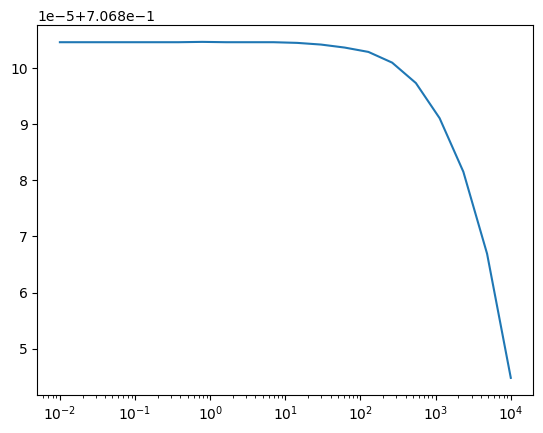

Minimum MSE = 0.7068448066711426 at alpha = 10000.0


In [27]:
ridge_mse = []

# Ridge Regression
# Typical values of alpha are 0.01 to 10,000
# 20 alpha values from 0.01 to 10000 in logarithmic scaling
alpha_counter = np.logspace(-2, 4, 20)

import warnings

with warnings.catch_warnings():
    ## to ignore the LinAlgWarning
    warnings.simplefilter('ignore')
    for a in tqdm(alpha_counter):
        ridge = Ridge(alpha=a)
        ridge.fit(train_x, train_y)
        ridge_y_pred = ridge.predict(test_x)
        ridge_mse.append(mean_squared_error(test_y, ridge_y_pred))
        del ridge



plt.plot(alpha_counter,ridge_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(ridge_mse)
print(f'Minimum MSE = {ridge_mse[min_mse_index]} at alpha = {alpha_counter[min_mse_index]}')
ra = alpha_counter[min_mse_index]

### Lasso Regression



Penalty: Takes the absolute value of the coefficients in loss function <br>


$$Cost Function:J(β) = RSS + α ∑ |βᵢ|$$

Behavior:
- Penalizes large coefficients by their absolute values.
- Performs feature selection: can set some coefficients to exactly 0, effectively removing irrelevant features.
- Best for situations where only a subset of predictors is relevant

100%|██████████| 20/20 [02:19<00:00,  6.99s/it]


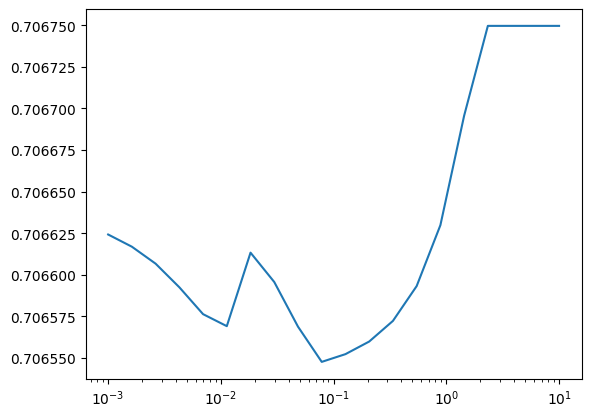

Minimum MSE = 0.7065476775169373 at alpha = 0.07847599703514611


In [28]:
lasso_mse = []
Lalpha_counter = np.logspace(-3, 1, 20)


for a in tqdm(Lalpha_counter):
    lasso = Lasso(alpha=a)
    lasso.fit(train_x, train_y)
    lasso_y_pred = lasso.predict(test_x)
    lasso_mse.append(mean_squared_error(test_y, lasso_y_pred))
    del lasso


plt.plot(Lalpha_counter,lasso_mse)
plt.xscale('log')
plt.show()



# argmin() finds index of minimnum value
min_mse_index = np.argmin(lasso_mse)
print(f'Minimum MSE = {lasso_mse[min_mse_index]} at alpha = {Lalpha_counter[min_mse_index]}')
la = Lalpha_counter[min_mse_index]

### Checking Elastic Results

Elastic Regression combines both Ridge and Lasso Regression


$$Cost Function:J(β) = RSS + α1 ∑βᵢ^2 + α2 ∑ |βᵢ|$$

Behavior:
- Hybrid approach: Balances feature selection (Lasso) and coefficient shrinkage (Ridge).
- Useful when there are multiple correlated features, and Lasso struggles to choose one.


In [29]:
## TAKES A LONG TIME

l1_alpha_values = np.logspace(-3, 2, 10)  # 10 values from 0.001 to 100
l1_ratios = np.linspace(0.1, 1.0, 10)  # 10 values from 0.1 to 1.0


elastic_mse_results = np.zeros((len(l1_alpha_values), len(l1_ratios)))

with tqdm(total=len(l1_alpha_values)*len(l1_ratios)) as progress_bar:
    for i, a in enumerate(l1_alpha_values):
        for j, l1 in enumerate(l1_ratios):
            elastic_net = ElasticNet(alpha=a, l1_ratio=l1)
            elastic_net.fit(train_x, train_y)
            elastic_net_y_pred = elastic_net.predict(test_x)
            elastic_mse_results[i, j] = mean_squared_error(test_y, elastic_net_y_pred)
            progress_bar.update(1)


min_mse_index = np.unravel_index(np.argmin(elastic_mse_results, axis=None), elastic_mse_results.shape)
optimal_alpha = l1_alpha_values[min_mse_index[0]]
optimal_l1_ratio = l1_ratios[min_mse_index[1]]



print(f"Optimal Alpha: {optimal_alpha}")
print(f"Optimal L1 Ratio: {optimal_l1_ratio}")
print(f"Minimum MSE: {elastic_mse_results[min_mse_index]}")

100%|██████████| 9/9 [01:02<00:00,  6.96s/it]

Optimal Alpha: 0.31622776601683794
Optimal L1 Ratio: 0.55
Minimum MSE: 0.7065568566322327


### Decision Trees and XGBoost

In [30]:
# Import libraries

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score



# Models for regression
regressors = {
    "Ridge Regression" : Ridge(alpha= ra),
    "Lasso Regression" : Lasso(alpha = la),
    "Elastic Regression" : ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(tree_method="hist")
}



# Metrics for regression

metrics = {
    "Mean Squared Error": mean_squared_error,
    "Mean Absolute Error": mean_absolute_error,
    "R^2 Score": r2_score,
    "Explained Variance": explained_variance_score
}

In [31]:
import time

use_val = True
results_train = {}
results_val = {}

for model in regressors:
    print(f"Model: {model}")
    
    start_time = time.time()
    
    regressors[model].fit(train_x, train_y)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    pred_y = regressors[model].predict(train_x)
    
    if use_val: 
        pred_y_val = regressors[model].predict(val_x)
    
    train_list = []
    val_list = []
    for metric in metrics:
        score = metrics[metric](train_y, pred_y)
        result_string = f"{metric}: Train - {round(score, 4)}"
        
        if use_val:
            score2 = metrics[metric](val_y, pred_y_val)
            result_string += f" Val - {round(score2, 4)}"
            val_list.append(score2)
            
        print(result_string)
        train_list.append(score)

    
    results_train[model] = train_list
    
    if use_val: 
        results_val[model] = val_list

    
    print(f"Time taken: {elapsed_time:.2f} seconds")
    print()
    

regression_results = pd.DataFrame({'Model': regressors, 'MSE': })

SyntaxError: expression expected after dictionary key and ':' (2875524329.py, line 47)

#### Neural Nets

In [32]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [33]:
input_shape=train_x.shape[1:]
print(input_shape)

(43,)


In [34]:
regressors['Neural Network'] = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_shape),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # Single output neuron for regression
    # We want to predict just Responder_6
    tf.keras.layers.Dense(1, activation=None)
])

# tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
regressors['Neural Network'].compile(loss="mse",
              optimizer="adam",
              metrics=["mse", "mae"])
EPOCHS = 3

history = regressors['Neural Network'].fit(train_x.values.astype('float32'), train_y.values.astype('float32'),
                             batch_size = 1024,
                             validation_data = (val_x.values.astype('float32'), val_y.values.astype('float32')) if use_val else None,
                             epochs=EPOCHS)

Epoch 1/3
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - loss: 0.6908 - mae: 0.5289 - mse: 0.6908 - val_loss: 0.7290 - val_mae: 0.5611 - val_mse: 0.7290
Epoch 2/3
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - loss: 0.6806 - mae: 0.5230 - mse: 0.6806 - val_loss: 0.7370 - val_mae: 0.5692 - val_mse: 0.7370
Epoch 3/3
3696/3696 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - loss: 0.6797 - mae: 0.5226 - mse: 0.6797 - val_loss: 0.7539 - val_mae: 0.5823 - val_mse: 0.7539


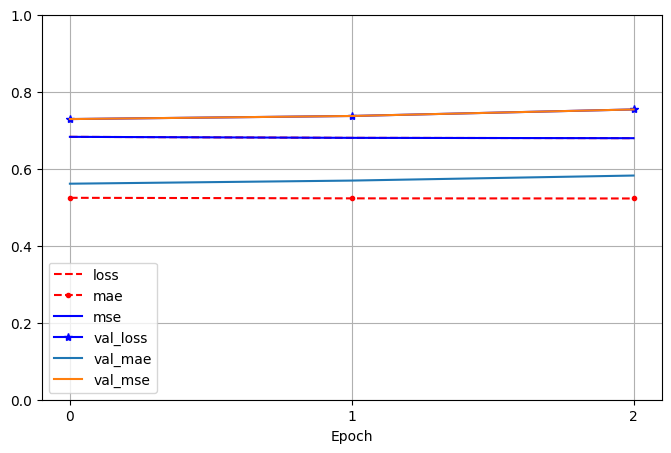

In [51]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.xticks(np.arange(EPOCHS))
plt.legend(loc="lower left")  # extra code
plt.show()

In [52]:
test_x = test_df[ALL_FEATURES]
test_y = test_df[['responder_6']]

In [53]:
# Performance
results_test = {}
for model in regressors:
  print(f"Model: {model}")
  if 'Neural Net' in model:
      pred_y_test = regressors[model].predict(test_x.values.astype('float32'),

                                             batch_size = 1024)

  else:
      pred_y_test = regressors[model].predict(test_x)
  results = []
  for metric in metrics:
    score = metrics[metric](test_y, pred_y_test)
    print(f"{metric}: {round(score,4)}")
    results.append(score)
  results_test[model] = results
  print()

Model: Ridge Regression


NotFittedError: This Ridge instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Feature Importance

In [ ]:
from xgboost import plot_importance
plt.figure(figsize = (10,20))
plot_importance(regressors["XGBoost"])
plt.savefig('feature_importance.png', dpi = 300)